In [2]:
from dotenv import load_dotenv
load_dotenv() # Reads the .env file in the current directory
import os
import re
import requests
from netCDF4 import Dataset


In [3]:
import json
import os
from dataclasses import dataclass
from datetime import date, timedelta
from io import BytesIO
from typing import Iterable, List, Optional, Tuple

from concurrent.futures import ThreadPoolExecutor, as_completed

import fsspec
import numpy as np
import requests
from PIL import Image

from io import BytesIO
from PIL import Image
import numpy as np

def image_bytes_to_fft_rgb(img_bytes: bytes) -> np.ndarray:
    """
    Convert image bytes (PNG/JPEG) to a 3-channel FFT (complex array).

    Returns:
        complex128 array of shape (H, W, 3).
    """
    with Image.open(BytesIO(img_bytes)) as im:
        im = im.convert("RGB")              # (H, W, 3)
        arr = np.array(im, dtype=np.float32)

    # FFT along spatial dimensions only, for all 3 channels
    f = np.fft.fft2(arr, axes=(0, 1))      # (H, W, 3)
    f_shifted = np.fft.fftshift(f, axes=(0, 1))
    return f_shifted.astype(np.complex128)


def fft_rgb_to_image(fft_arr: np.ndarray) -> Image.Image:
    """
    Invert a 3-channel FFT back into an RGB PIL.Image.

    fft_arr must come from image_bytes_to_fft_rgb.
    """
    f_unshift = np.fft.ifftshift(fft_arr, axes=(0, 1))
    img_complex = np.fft.ifft2(f_unshift, axes=(0, 1))  # (H, W, 3)
    img_real = np.real(img_complex)
    img_real = np.clip(img_real, 0, 255).astype(np.uint8)
    return Image.fromarray(img_real, mode="RGB")

# ------------------------------------------------------------------------
#  Bounding box for Calgary (your coordinates)
# ------------------------------------------------------------------------

LAT_N = 51.3769
LAT_S = 50.7726
LON_W = -114.3362
LON_E = -113.7319

# Worldview Snapshots endpoint
WORLDVIEW_SNAPSHOT_URL = "https://wvs.earthdata.nasa.gov/api/v1/snapshot"

# Default GIBS layer (can be overridden)
DEFAULT_LAYER = "MODIS_Terra_CorrectedReflectance_TrueColor"

# Default image size (tweak as needed)
DEFAULT_WIDTH = 256
DEFAULT_HEIGHT = 256

# Side length of the low-frequency FFT block we keep (K x K).
# Must be <= 256. K = 80 gives a representation smaller than the original image.
KEEP_LOWFREQ_SIZE = 80

# ------------------------------------------------------------------------
#  Configuration dataclass
# ------------------------------------------------------------------------

@dataclass
class WorldviewConfig:
    """
    Configuration for NASA Worldview snapshot requests.
    """
    layer: str = DEFAULT_LAYER
    width: int = DEFAULT_WIDTH
    height: int = DEFAULT_HEIGHT
    crs: str = "EPSG:4326"
    format: str = "image/png"


# ------------------------------------------------------------------------
#  Date helpers
# ------------------------------------------------------------------------

def summer_dates(year: int) -> List[date]:
    """
    Return all "summer" dates for a given year.

    Here we define summer as June 1 (inclusive) to September 1 (exclusive).
    Adjust as needed if you want a different definition.
    """
    start = date(year, 6, 1)
    end = date(year, 9, 1)  # exclusive
    cur = start
    out: List[date] = []
    while cur < end:
        out.append(cur)
        cur += timedelta(days=1)
    return out


# ------------------------------------------------------------------------
#  Worldview Snapshot client
# ------------------------------------------------------------------------

def make_snapshot_url(
    d: date,
    cfg: Optional[WorldviewConfig] = None,
) -> str:
    if cfg is None:
        cfg = WorldviewConfig()

    # Choose a UTC time likely to be daylight in Calgary.
    # Calgary is around UTC-7 in summer, so 19:00Z ~ 12:00 local.
    time_str = f"{d.isoformat()}T19:00:00Z"

    params = {
        "REQUEST": "GetSnapshot",
        "TIME": f"{d.isoformat()}T00:00:00Z",
        # south, west, north, east (lat, lon order that worked)
        "BBOX": "50.7726,-114.3362,51.3769,-113.7319",
        "CRS": "EPSG:4326",
        "LAYERS": "MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m",
        "WRAP": "day,x",
        "FORMAT": "image/jpeg",
        "WIDTH": "275",
        "HEIGHT": "275",
        "colormaps": "",
        "ts": "1763062140925",   # UI timestamp – not required for correctness
    }

    qs = "&".join(f"{k}={v}" for k, v in params.items())
    return f"{WORLDVIEW_SNAPSHOT_URL}?{qs}"

def download_snapshot_bytes(
    d: date,
    cfg: Optional[WorldviewConfig] = None,
    session: Optional[requests.Session] = None,
    timeout: int = 60,
) -> bytes:

    if cfg is None:
        cfg = WorldviewConfig()
    if session is None:
        session = requests.Session()

    url = make_snapshot_url(d, cfg)
    resp = session.get(url, timeout=timeout)
    resp.raise_for_status()
    return resp.content


# ------------------------------------------------------------------------
#  FFT computation
# ------------------------------------------------------------------------

def image_bytes_to_fft(
    img_bytes: bytes,
    to_grayscale: bool = True,
) -> np.ndarray:
    with Image.open(BytesIO(img_bytes)) as im:
        if to_grayscale:
            im = im.convert("L")  # 8-bit grayscale
        arr = np.array(im, dtype=np.float32)

    f = np.fft.fft2(arr)
    f_shifted = np.fft.fftshift(f)
    return f_shifted.astype(np.complex128)


# ------------------------------------------------------------------------
#  fsspec helpers (for bronze datalake writes)
# ------------------------------------------------------------------------

def get_fs_and_path(
    base_prefix: str,
    rel_path: str,
    storage_options: Optional[dict] = None,
) -> Tuple[fsspec.AbstractFileSystem, str]:
    storage_options = storage_options or {}
    full_path = base_prefix.rstrip("/") + "/" + rel_path.lstrip("/")
    fs, _, paths = fsspec.get_fs_token_paths(full_path, storage_options=storage_options)
    # paths[0] is the normalized path without protocol
    return fs, paths[0]


def save_fft_to_bronze(
    fft_arr: np.ndarray,
    d: date,
    cfg: WorldviewConfig,
    bronze_prefix: str,
    storage_options: Optional[dict] = None,
) -> None:
    storage_options = storage_options or {}

    rel_dir = f"worldview_fft/year={d.year}"
    safe_layer = cfg.layer.replace("/", "_")
    fname = f"worldview_fft_{d.isoformat()}_{safe_layer}.npz"
    rel_path = f"{rel_dir}/{fname}"

    fs, fs_path = get_fs_and_path(bronze_prefix, rel_path, storage_options)

    meta = {
        "date": d.isoformat(),
        "layer": cfg.layer,
        "lat_n": LAT_N,
        "lat_s": LAT_S,
        "lon_w": LON_W,
        "lon_e": LON_E,
        "width": cfg.width,
        "height": cfg.height,
    }

    parent = os.path.dirname(fs_path)
    if parent and not fs.exists(parent):
        fs.mkdirs(parent, exist_ok=True)

    with fs.open(fs_path, "wb") as f:
        np.savez_compressed(
            f,
            fft=fft_arr,
            meta=json.dumps(meta),
        )
def process_dates_to_fft(
    dates: Iterable[date],
    bronze_prefix: str,
    storage_options: Optional[dict] = None,
    cfg: Optional[WorldviewConfig] = None,
    max_workers: int = 4,
) -> None:
    if cfg is None:
        cfg = WorldviewConfig()

    storage_options = storage_options or {}
    session = requests.Session()

    def _worker(d: date):
        try:
            img_bytes = download_snapshot_bytes(d, cfg=cfg, session=session)
            fft_arr = image_bytes_to_fft_rgb(img_bytes)
    
            save_fft_to_bronze(
                fft_arr=fft_arr,
                d=d,
                cfg=cfg,
                bronze_prefix=bronze_prefix,
                storage_options=storage_options,
            )
            return d, True, None
        except Exception as e:
            return d, False, str(e)


    dates_list = list(dates)
    print(f"Processing {len(dates_list)} dates with max_workers={max_workers}...")

    successes = 0
    failures = 0

    with ThreadPoolExecutor(max_workers=max_workers) as pool:
        futures = {pool.submit(_worker, d): d for d in dates_list}
        for fut in as_completed(futures):
            d = futures[fut]
            try:
                _, ok, err = fut.result()
            except Exception as e:
                ok = False
                err = str(e)

            if ok:
                successes += 1
                print(f"[OK] {d.isoformat()}")
            else:
                failures += 1
                print(f"[FAIL] {d.isoformat()} -> {err}")

    print(f"Done. Successes={successes}, Failures={failures}")


def process_summers_for_year_range(
    start_year: int,
    end_year: int,
    bronze_prefix: str,
    storage_options: Optional[dict] = None,
    cfg: Optional[WorldviewConfig] = None,
    max_workers: int = 4,
) -> None:
    all_dates: List[date] = []
    for yr in range(start_year, end_year + 1):
        all_dates.extend(summer_dates(yr))

    process_dates_to_fft(
        dates=all_dates,
        bronze_prefix=bronze_prefix,
        storage_options=storage_options,
        cfg=cfg,
        max_workers=max_workers,
    )


# ------------------------------------------------------------------------
#  Optional: simple CLI entry point
# ------------------------------------------------------------------------

URL: https://wvs.earthdata.nasa.gov/api/v1/snapshot?REQUEST=GetSnapshot&TIME=2001-07-04T00:00:00Z&BBOX=50.7726,-114.3362,51.3769,-113.7319&CRS=EPSG:4326&LAYERS=MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m&WRAP=day,x&FORMAT=image/jpeg&WIDTH=275&HEIGHT=275&colormaps=&ts=1763062140925


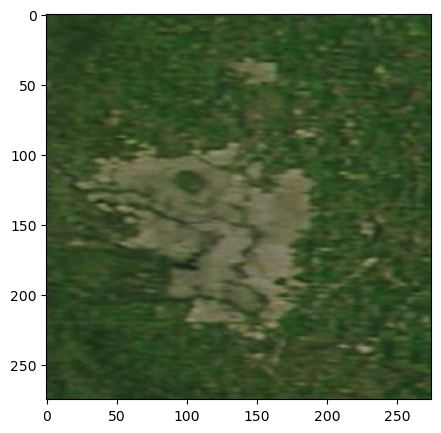

In [4]:
from datetime import date
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
cfg = WorldviewConfig(
    layer="MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m",

)

url = make_snapshot_url(date(2001, 7, 4), cfg)
print("URL:", url)

raw_bytes = download_snapshot_bytes(date(2001, 7, 4), cfg)
img = Image.open(BytesIO(raw_bytes))

plt.figure(figsize=(5, 5))
plt.imshow(img)



In [5]:
from io import BytesIO
from PIL import Image
import numpy as np

def image_bytes_to_fft_rgb(img_bytes: bytes) -> np.ndarray:
    """
    Convert image bytes (PNG/JPEG) to a cropped low-frequency FFT block.

    Assumptions:
      - Image is exactly 256x256 RGB (no resizing is performed here).
      - We keep a central KEEP_LOWFREQ_SIZE x KEEP_LOWFREQ_SIZE block
        in the frequency domain, across all 3 channels.

    Returns:
      complex64 array of shape (K, K, 3), where K = KEEP_LOWFREQ_SIZE.
    """
    with Image.open(BytesIO(img_bytes)) as im:
        im = im.convert("RGB")
        arr = np.array(im, dtype=np.float32)   # (H, W, 3)

    H, W, C = arr.shape
    if (H, W, C) != (256, 256, 3):
        raise ValueError(f"Expected 256x256 RGB image, got {arr.shape}")

    # 1) Full FFT along spatial dimensions
    F = np.fft.fft2(arr, axes=(0, 1))         # (256, 256, 3)
    F_shift = np.fft.fftshift(F, axes=(0, 1))

    # 2) Crop central low-frequency square of size K x K
    K = min(KEEP_LOWFREQ_SIZE, H, W)
    cy, cx = H // 2, W // 2                   # (128, 128)
    half = K // 2

    y0 = cy - half
    y1 = y0 + K
    x0 = cx - half
    x1 = x0 + K

    low_fft = F_shift[y0:y1, x0:x1, :]        # (K, K, 3)

    # 3) Store as complex64 to reduce size
    return low_fft.astype(np.complex64)


In [7]:
def fft_rgb_to_image(fft_arr: np.ndarray) -> Image.Image:
    """
    Approximate inverse of image_bytes_to_fft_rgb.

    fft_arr is a K x K x 3 low-frequency block (complex),
    which we zero-pad into a 256 x 256 x 3 FFT grid,
    then inverse-FFT to recover a 256x256 RGB image.

    The result is a slightly blurred version of the original
    (high frequencies are discarded), but the size on disk is smaller.
    """
    fft_arr = np.asarray(fft_arr)
    if fft_arr.ndim != 3 or fft_arr.shape[2] != 3:
        raise ValueError(f"Expected fft_arr of shape (K, K, 3), got {fft_arr.shape}")

    K_h, K_w, C = fft_arr.shape
    if K_h != K_w:
        raise ValueError(f"Expected a square low-frequency block, got {fft_arr.shape}")
    K = K_h
    if C != 3:
        raise ValueError("Expected 3 channels (RGB) in fft_arr")

    H = W = 256

    # 1) Allocate full FFT grid and place low-frequency block in the center
    full_fft = np.zeros((H, W, C), dtype=fft_arr.dtype)

    cy, cx = H // 2, W // 2
    half = K // 2

    y0 = cy - half
    y1 = y0 + K
    x0 = cx - half
    x1 = x0 + K

    full_fft[y0:y1, x0:x1, :] = fft_arr

    # 2) Undo shift and inverse FFT
    F_unshift = np.fft.ifftshift(full_fft, axes=(0, 1))
    img_complex = np.fft.ifft2(F_unshift, axes=(0, 1))  # (256, 256, 3)
    img_real = np.real(img_complex)

    # 3) Clip and cast to uint8
    img_real = np.clip(img_real, 0, 255).astype(np.uint8)
    return Image.fromarray(img_real, mode="RGB")


In [8]:
from datetime import date
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np

# 1) Get a test snapshot
cfg = WorldviewConfig(
    layer="MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m",
    width=512,
    height=512,
)

d = date(2001, 7, 4)
raw_bytes = download_snapshot_bytes(d, cfg)

# Original image (for comparison)
orig_img = Image.open(BytesIO(raw_bytes)).convert("RGB")

# 2) Forward RGB FFT
fft_rgb = image_bytes_to_fft_rgb(raw_bytes)   # (H, W, 3) complex

# 3) Inverse FFT back to color
recon_img = fft_rgb_to_image(fft_rgb)

# 4) Compare numerically
orig_arr = np.array(orig_img, dtype=np.float32)
recon_arr = np.array(recon_img, dtype=np.float32)

diff = np.abs(orig_arr - recon_arr)
print("Max absolute difference:", diff.max())
print("Mean absolute difference:", diff.mean())

# 5) Show side-by-side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.axis("off")
plt.title("Original RGB")

plt.subplot(1, 2, 2)
plt.imshow(recon_img)
plt.axis("off")
plt.title("Reconstructed from FFT (RGB)")

plt.show()


ValueError: Expected 256x256 RGB image, got (275, 275, 3)

In [9]:
from datetime import date
import os
import importlib

bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"
ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
storage_options = {
    "account_name": ACCOUNT_NAME,
    "account_key": ACCOUNT_KEY,
}

cfg = WorldviewConfig(
    layer="MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m",
    # width/height default to 512; set here if you want to override
)

start = summer_dates(2000)[0]
end = summer_dates(2025)[-1]
process_summers_for_year_range(
    start_year=start.year,
    end_year=end.year,
    bronze_prefix=bronze_prefix,
    storage_options=storage_options,
    cfg=cfg,
    max_workers=12,
)



Processing 2392 dates with max_workers=12...
[OK] 2000-06-09
[OK] 2000-06-04
[OK] 2000-06-12
[OK] 2000-06-02
[OK] 2000-06-01
[OK] 2000-06-03
[OK] 2000-06-05
[OK] 2000-06-06
[OK] 2000-06-07
[OK] 2000-06-16
[OK] 2000-06-15
[OK] 2000-06-13
[OK] 2000-06-14
[OK] 2000-06-20
[OK] 2000-06-17
[OK] 2000-06-21
[OK] 2000-06-19
[OK] 2000-06-18
[OK] 2000-06-24
[OK] 2000-06-22
[OK] 2000-06-27
[OK] 2000-06-25
[OK] 2000-06-23
[OK] 2000-06-26
[OK] 2000-06-28
[OK] 2000-06-29
[OK] 2000-06-30
[OK] 2000-07-01
[OK] 2000-07-02
[OK] 2000-07-03
[OK] 2000-07-04
[OK] 2000-07-07
[OK] 2000-07-05
[OK] 2000-07-09
[OK] 2000-07-06
[OK] 2000-06-11
[OK] 2000-07-08
[OK] 2000-06-10
[OK] 2000-06-08
[OK] 2000-07-10
[OK] 2000-07-11
[OK] 2000-07-12
[OK] 2000-07-13
[OK] 2000-07-14
[OK] 2000-07-16
[OK] 2000-07-15
[OK] 2000-07-19
[OK] 2000-07-18
[OK] 2000-07-17
[OK] 2000-07-20
[OK] 2000-07-22
[OK] 2000-07-21
[OK] 2000-07-23
[OK] 2000-07-24
[OK] 2000-07-25
[OK] 2000-07-27
[OK] 2000-07-29
[OK] 2000-07-26
[OK] 2000-07-28
[OK] 2000-0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.8554806938539401..16.228978132461236].


FFT shape: (275, 275, 3)
Meta: {'date': '2020-07-01', 'layer': 'MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m', 'lat_n': 51.3769, 'lat_s': 50.7726, 'lon_w': -114.3362, 'lon_e': -113.7319, 'width': 512, 'height': 512}


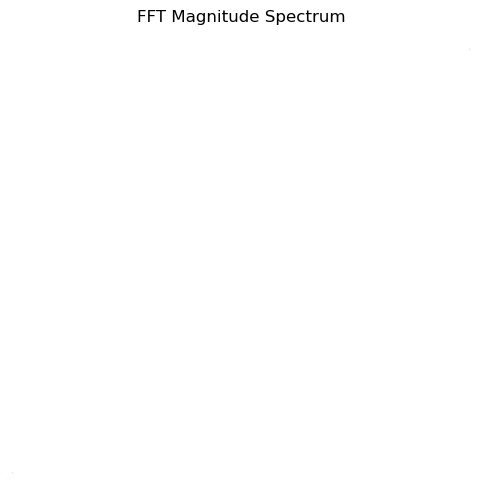

In [10]:
import numpy as np
import json
import fsspec
import matplotlib.pyplot as plt

bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"
# One specific file to inspect
path = (
    bronze_prefix +
    "/worldview_fft/year=2020/worldview_fft_2020-07-01_MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m.npz"
)
ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
storage_options = {
    "account_name": ACCOUNT_NAME,
    "account_key": ACCOUNT_KEY,
}
# ✅ Correct unpacking: fs, token, paths
fs, _, paths = fsspec.get_fs_token_paths(path, storage_options=storage_options)

with fs.open(paths[0], "rb") as f:
    data = np.load(f, allow_pickle=True)
    fft_arr = data["fft"]
    meta = json.loads(data["meta"].item())

print("FFT shape:", fft_arr.shape)
print("Meta:", meta)

# Show magnitude spectrum (log scale so it's visible)
magnitude = np.abs(fft_arr)
log_mag = np.log1p(magnitude)

plt.figure(figsize=(6, 6))
plt.imshow(log_mag, cmap="gray")
plt.title("FFT Magnitude Spectrum")
plt.axis("off")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-6567.612193967341..49729.00003826727].


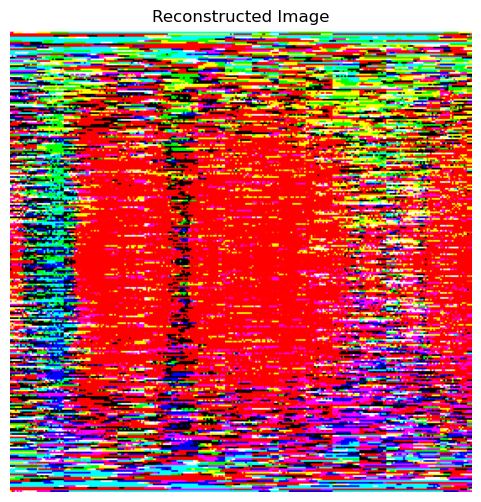

In [11]:
# Undo fftshift and invert
f_unshift = np.fft.ifftshift(fft_arr)
reconstructed = np.fft.ifft2(f_unshift).real

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="gray")
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()


In [12]:
ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
storage_options = {
    "account_name": ACCOUNT_NAME,
    "account_key": ACCOUNT_KEY,
}
# 
vfrom datetime import date
import importlib

importlib.reload(worldview_fft)
cfg = WorldviewConfig(
    layer="MODIS_Terra_CorrectedReflectance_TrueColor,Coastlines_15m",
    width=512,
    height=512,
)
test_date = summer_dates(2020)[0]
print("Testing single date:", test_date)

process_summers_for_year_range(
    start_year=test_date.year,
    end_year=test_date.year,
    bronze_prefix=bronze_prefix,
    storage_options=storage_options,
    cfg=cfg,
    max_workers=1,  # single thread for the smoke test
)


SyntaxError: invalid syntax (2936528022.py, line 8)

In [ ]:
bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"
ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
storage_options = {
    "account_name": ACCOUNT_NAME,
    "account_key": ACCOUNT_KEY,
}
bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"

from datetime import date

dates = [date(2000, 6, 1), date(2025, 8, 31)]
process_dates_to_fft(
    dates=dates,
    bronze_prefix=bronze_prefix,
    storage_options=storage_options,
    cfg=cfg,
    max_workers=2,
)


In [ ]:
import numpy as np
import json
import fsspec
import matplotlib.pyplot as plt

bronze_prefix = "abfs://raw@ucalgarydatalake01.dfs.core.windows.net/worldview_fft"
# One specific file to inspect
path = (
    bronze_prefix +
    "/worldview_fft/year=2000/worldview_fft_2000-06-01_MODIS_Terra_CorrectedReflectance_TrueColor.npz"
)
ACCOUNT_NAME = os.environ.get("ACCOUNT_NAME")
ACCOUNT_KEY = os.environ.get("ACCOUNT_KEY")
storage_options = {
    "account_name": ACCOUNT_NAME,
    "account_key": ACCOUNT_KEY,
}
# ✅ Correct unpacking: fs, token, paths
fs, _, paths = fsspec.get_fs_token_paths(path, storage_options=storage_options)

with fs.open(paths[0], "rb") as f:
    data = np.load(f, allow_pickle=True)
    fft_arr = data["fft"]
    meta = json.loads(data["meta"].item())

print("FFT shape:", fft_arr.shape)
print("Meta:", meta)

# Show magnitude spectrum (log scale so it's visible)
magnitude = np.abs(fft_arr)
log_mag = np.log1p(magnitude)

plt.figure(figsize=(6, 6))
plt.imshow(log_mag, cmap="gray")
plt.title("FFT Magnitude Spectrum")
plt.axis("off")
plt.show()




In [ ]:
# Undo fftshift and invert
f_unshift = np.fft.ifftshift(fft_arr)
reconstructed = np.fft.ifft2(f_unshift).real

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed, cmap="gray")
plt.title("Reconstructed Image")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np

print("fft dtype:", fft_arr.dtype)
print("fft real min/max:", fft_arr.real.min(), fft_arr.real.max())
print("fft imag min/max:", fft_arr.imag.min(), fft_arr.imag.max())

abs_mag = np.abs(fft_arr)
print("abs min/max:", abs_mag.min(), abs_mag.max())
print("all close to zero?", np.allclose(fft_arr, 0))


In [ ]:
from datetime import date
from io import BytesIO
from PIL import Image

from worldview_fft import WorldviewConfig, download_snapshot_bytes

cfg = WorldviewConfig(
    layer="MODIS_Terra_CorrectedReflectance_TrueColor",
    width=512,
    height=512,
)

raw_bytes = download_snapshot_bytes(date(2019, 6, 1), cfg=cfg)

img = Image.open(BytesIO(raw_bytes))
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Raw NASA Worldview Snapshot")
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
from io import BytesIO
from PIL import Image

img = Image.open(BytesIO(raw_bytes))
arr = np.array(img)

print("Image mode:", img.mode)
print("Shape:", arr.shape)
print("min / max / mean:", arr.min(), arr.max(), arr.mean())
print("all zeros?", np.all(arr == 0))

